# Importing all the required libraries

In [21]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import os
import torch
from torchvision.utils import make_grid
import torch.nn as nn
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from IPython.display import Image
import matplotlib.pyplot as plt
from skimage.io import imread,imshow
%matplotlib inline

In [22]:
DATA_DIR = '../Dataset'
print(os.listdir(DATA_DIR))

['Data']


# Images, Display Functions, Data Set, Data Loader

In [23]:
image_size = 64 #Target image size
latent_size = 128 #Size of the latent vector
batch_size = 1 #Batch size
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) #Mean and standard deviation of the dataset used to normalize to [-1,1]

In [24]:
train_dataset = ImageFolder(DATA_DIR, transform=T.Compose([T.Resize(image_size),T.CenterCrop(image_size),T.ToTensor(),T.Normalize(*stats)]))
Train_DataLoader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [25]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

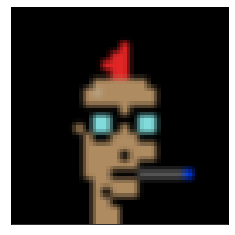

In [26]:
def show_images(images, num_max=batch_size):
    '''
    Function to show images in a grid
    '''
    fig, ax = plt.subplots(figsize=(4,4))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:num_max]), nrow=batch_size).permute(1, 2, 0)) #permute to change the order of the axes i.e. from (C,H,W) to (H,W,C)
    
def show_batch(dataloader, num_max=batch_size):
    '''
    Function to show a batch of images from the dataloader
    '''
    for images, _ in dataloader:
        show_images(images, num_max)
        break

show_batch(Train_DataLoader)

In [27]:
def get_default_device():
    """
    Select GPU if available, else CPU
    """
    return torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def to_device(data, device):
    """
    Move tensors to chosen device
    """
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DataLoaderDevice():
    """
    Wrap a dataloader to move data to a device
    """
    def __init__(self, dataloader, device):
        self.device = device
        self.dataloader = dataloader
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dataloader: 
            yield to_device(b, self.device)

    def __len__(self):
        """Count of batches"""
        return len(self.dataloader)

In [28]:
device = get_default_device()
print('The default device is:',device)

The default device is: cpu


In [29]:
Train_DataLoader = DataLoaderDevice(Train_DataLoader, device)

# GAN Architecture, Discriminator, Generator

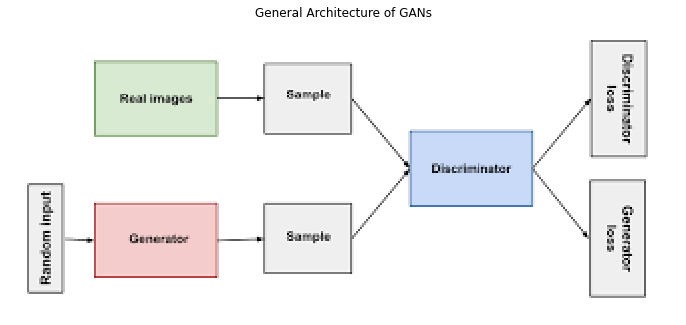

In [30]:
Architecture_GAN = imread('../GAN Architecture/Gan Architecture.png')
plt.figure(figsize=(10,10))
imshow(Architecture_GAN)
plt.axis('off')
plt.title('General Architecture of GANs')
plt.show()

In [31]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

discriminator = to_device(discriminator, device)

In [32]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

generator = to_device(generator, device)

In [33]:
def Generate_Noise(batch, latent_size):
    return torch.randn(batch, latent_size, 1, 1, device=device)

In [34]:
def Discriminator_Training(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = Generate_Noise(batch_size, latent_size)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [35]:
def Generator_Training(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = Generate_Noise(batch_size, latent_size)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

# Training

In [36]:
sample_dir = 'generated' #Directory to save generated images
os.makedirs(sample_dir, exist_ok=True) #Create directory if it doesn't exist

In [37]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-DCGAN-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(4,4))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(denorm(fake_images.cpu().detach()), nrow=batch_size).permute(1, 2, 0))
        plt.show()

Saving generated-images-DCGAN-0000.png


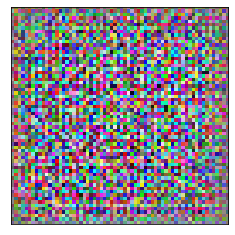

In [38]:
fixed_latent = Generate_Noise(batch_size, latent_size)
save_samples(0, fixed_latent)

In [39]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(Train_DataLoader):
            # Train discriminator
            loss_d, real_score, fake_score = Discriminator_Training(real_images, opt_d)
            # Train generator
            loss_g = Generator_Training(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        latent = Generate_Noise(batch_size, latent_size)
        save_samples(epoch+start_idx, latent, show=True)

        # Save the model checkpoints 
        Discriminator_File = './Models/' + 'Discriminator_DCGAN_CheckPoint_' + str(epoch+start_idx) + '.pth'
        Generator_File = './Models/' + 'Generator_DCGAN_CheckPoint_' + str(epoch+start_idx) + '.pth'
        torch.save(generator.state_dict(), Discriminator_File)
        torch.save(discriminator.state_dict(), Generator_File)
    
    return losses_g, losses_d, real_scores, fake_scores

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch [1/11], loss_g: 2.9689, loss_d: 0.1615, real_score: 1.0000, fake_score: 0.1491
Saving generated-images-DCGAN-0001.png


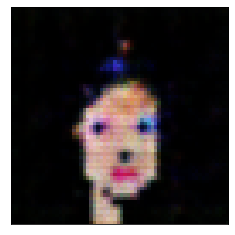

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch [2/11], loss_g: 3.5759, loss_d: 2.5218, real_score: 1.0000, fake_score: 0.9197
Saving generated-images-DCGAN-0002.png


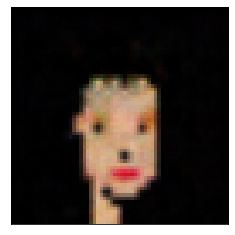

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch [3/11], loss_g: 1.5720, loss_d: 0.2409, real_score: 0.9990, fake_score: 0.2133
Saving generated-images-DCGAN-0003.png


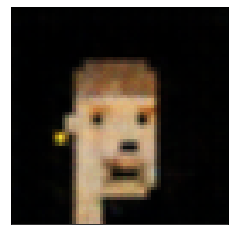

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch [4/11], loss_g: 1.8066, loss_d: 0.3680, real_score: 0.7127, fake_score: 0.0289
Saving generated-images-DCGAN-0004.png


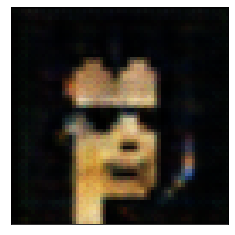

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch [5/11], loss_g: 5.4546, loss_d: 0.0139, real_score: 1.0000, fake_score: 0.0138
Saving generated-images-DCGAN-0005.png


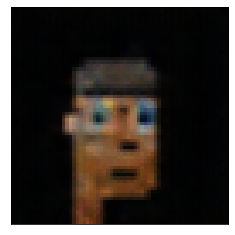

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch [6/11], loss_g: 5.6454, loss_d: 0.0035, real_score: 1.0000, fake_score: 0.0035
Saving generated-images-DCGAN-0006.png


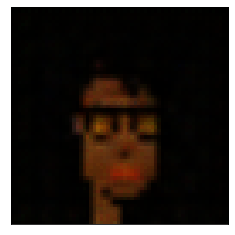

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch [7/11], loss_g: 4.1439, loss_d: 0.0287, real_score: 0.9968, fake_score: 0.0252
Saving generated-images-DCGAN-0007.png


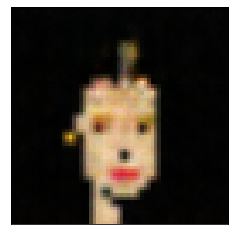

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch [8/11], loss_g: 5.0520, loss_d: 0.0087, real_score: 1.0000, fake_score: 0.0087
Saving generated-images-DCGAN-0008.png


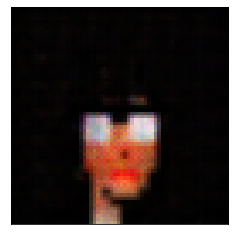

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch [9/11], loss_g: 5.2916, loss_d: 0.0060, real_score: 1.0000, fake_score: 0.0060
Saving generated-images-DCGAN-0009.png


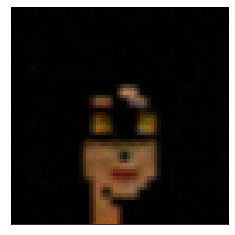

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch [10/11], loss_g: 4.5853, loss_d: 0.0336, real_score: 0.9876, fake_score: 0.0210
Saving generated-images-DCGAN-0010.png


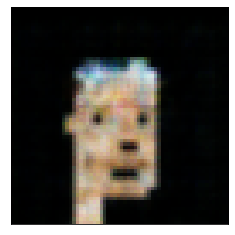

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch [11/11], loss_g: 4.6603, loss_d: 0.0106, real_score: 1.0000, fake_score: 0.0106
Saving generated-images-DCGAN-0011.png


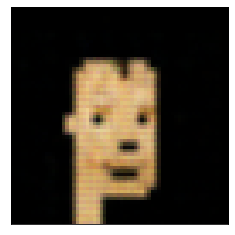

Training complete


In [40]:
lr = 0.0002
epochs = 11
history = fit(epochs, lr)
losses_g, losses_d, real_scores, fake_scores = history
print("Training complete")

In [41]:
def Display_Generated_Images(path):
    Image(path)
    plt.show()

Display_Generated_Images('./generated/generated-images-DCGAN-0001.png')
Display_Generated_Images('./generated/generated-images-DCGAN-0005.png')
Display_Generated_Images('./generated/generated-images-DCGAN-0009.png')

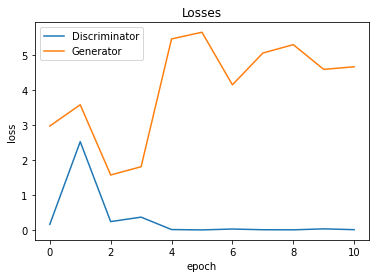

In [42]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses')
plt.savefig('Losses_DCGAN.png')
plt.show()

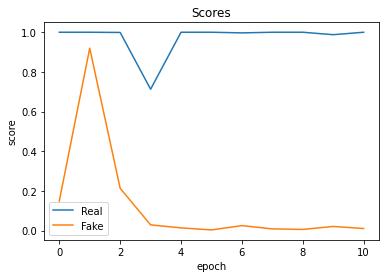

In [43]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores')
plt.savefig('Scores_DCGAN.png')
plt.show()